In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure
from sklearn.decomposition import PCA

In [2]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7


def load_long_df(version=4, df_version=0):
    df = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_syllable_df_v{df_version:02d}.parquet"
    )
    df = relabel_by_usage(df, return_map=False)
    df["mouse_id"] = df["subject_name"].str[:5]
    df = df[~df["mouse_id"].str.lower().str.contains("c")]
    df = df[~df["mouse_id"].str.lower().str.contains("long")]
    ages = df.groupby("mouse_id", sort=False)['date'].transform(age)
    df["age"] = ages

    session_length = df.groupby("uuid")["timestamps"].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df["uuid"].isin(remove_uuids)]

    usage_df = (
        df.query("onsets")
        .groupby(["age", "mouse_id", "uuid"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_df.name = "usage"
    usage_df = usage_df.reset_index()
    usage_mtx = usage_df.pivot_table(
        values="usage", columns="relabeled_syllables", index=["age", "mouse_id", "uuid"]
    ).fillna(0)

    # remove sessions with abnormally high syllable usage
    usage_mtx = usage_mtx[~(usage_mtx > 0.15).any(axis=1)]

    # remove sessions with abnormally few syllables used
    usage_mtx = usage_mtx[(usage_mtx > 0).sum(axis=1) > 20]
    return usage_mtx.drop('05_02', level='mouse_id')

In [3]:
df = load_long_df()

In [13]:
pca = PCA()
pcs = pca.fit_transform(df)

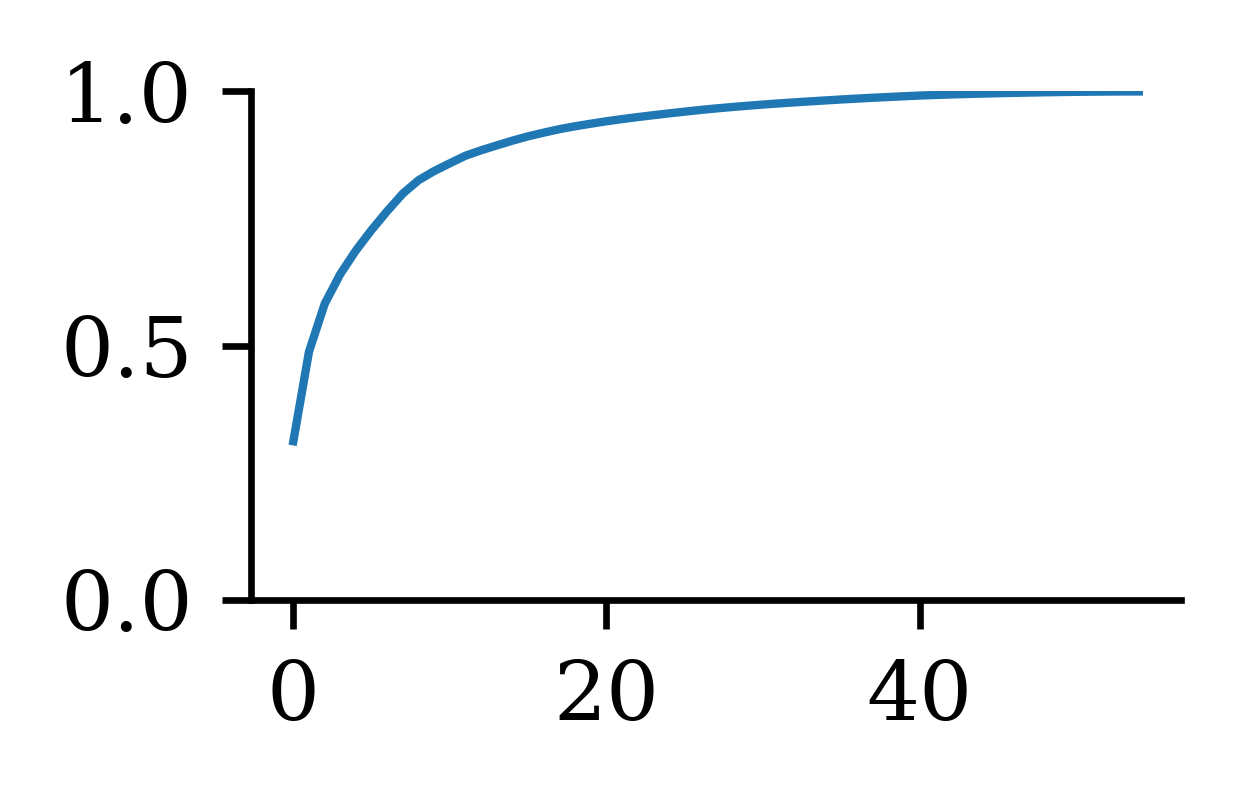

In [14]:
figure(2, 1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=1)
ax = plt.gca()
ax.set(ylim=(0, 1))
sns.despine()

In [16]:
np.cumsum(pca.explained_variance_ratio_)[:15]

array([0.31174172, 0.48815576, 0.58208172, 0.64083386, 0.68729716,
       0.7276975 , 0.76476672, 0.79928595, 0.82548466, 0.8434666 ,
       0.85877566, 0.8736746 , 0.8843069 , 0.89393869, 0.90329393])

In [17]:
pca.explained_variance_ratio_[:15]

array([0.31174172, 0.17641404, 0.09392596, 0.05875214, 0.04646331,
       0.04040034, 0.03706922, 0.03451923, 0.02619871, 0.01798194,
       0.01530906, 0.01489894, 0.0106323 , 0.00963179, 0.00935524])

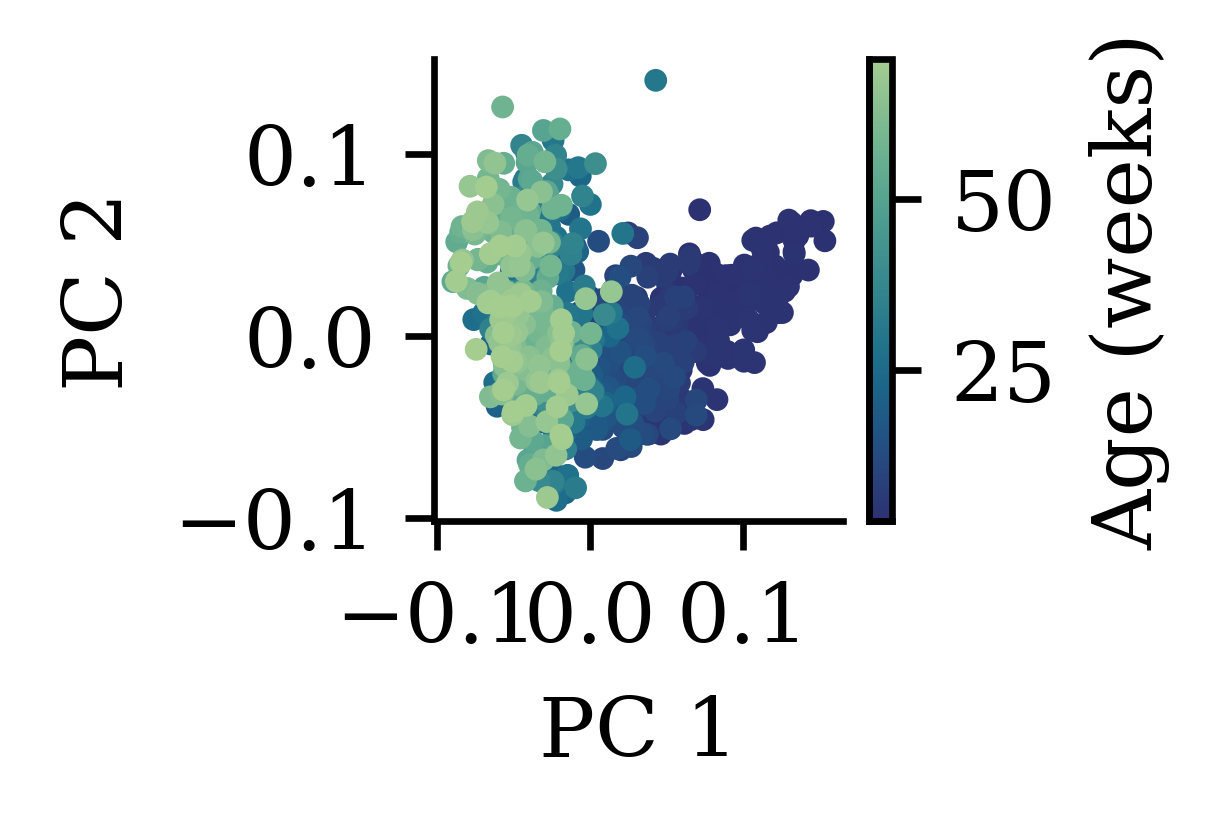

In [15]:
fig = figure(1.1, 1)
ax = fig.gca()
im = ax.scatter(*pcs[:, :2].T, c=df.index.get_level_values('age'), cmap='crest_r', s=3)
ax.set(xlabel='PC 1', ylabel='PC 2')
fig.colorbar(im, label='Age (weeks)')
sns.despine()
# saver(fig, 'pc1-vs-pc2');